# Audio Reproduction with Loudspeakers


[return to main page](index.ipynb)

For the analysis of existing and the development of new reproduction methods,
simulations are a very helpful tool.
In the following exercises, we will simulate some sound fields by means of the
[Sound Field Synthesis (SFS) Toolbox for Python](http://sfs.readthedocs.org/).

These simulations are assuming *free-field* conditions, i.e. the simulated
loudspeakers are not located in a conventional room but in an infinitely large
volume of air.
In addition, the loudspeakers are modeled as idealized point sources which radiate
uniformly in all directions and for all frequencies.

## Preparations

First, let's install SFS-Python:

    git clone https://github.com/sfstoolbox/sfs-python.git
    cd sfs-python
    python3 setup.py develop --user

If you have only Python 3 installed on your system, you may have to use `python` instead of `python3`.

Once installed, we can import it into our Python session:

In [1]:
import sfs

While we're at it, let's also import some other stuff and enable plotting:

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

We will simulate the sound pressure at different points in space.
To specify the area we are interested in, we create a *grid*:

In [3]:
grid = sfs.util.xyz_grid([-2, 2], [-2, 2], 0, spacing=0.02)

Have a look at the [documentation](http://sfs.readthedocs.org/en/latest/#sfs.util.xyz_grid) to find out what the function parameters mean.

*Exercise:* What does the third argument mean in our case?
How many dimensions does our grid have?

## Sound Sources

Before we start analyzing loudspeaker systems, let's see what kinds of sound
sources we can simulate.

### Point Source

Let's plot a [point source](http://sfs.readthedocs.org/#sfs.mono.source.point) at the position $(0, 1.5, 0)$ metres with a frequency of 1000 Hertz.

In [4]:
x0 = 0, 1.5, 0
f = 1000  # Hz
omega = 2 * np.pi * f

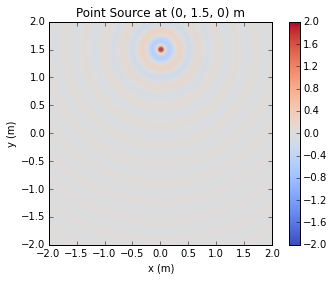

In [5]:
p_point = sfs.mono.source.point(omega, x0, None, grid)
sfs.plot.soundfield(p_point, grid)
plt.title("Point Source at {} m".format(x0));

The amplitude of the sound field is a bit weak ...

*Exercise:* Multiply the sound pressure field by a scaling factor of $4\pi$ to get an appropriate amplitude.

In [6]:
scaling_factor_point_source = 4 * np.pi

*Exercise:* Try different source positions and different frequencies.

### Line Source

Let's plot a [line source](http://sfs.readthedocs.org/#sfs.mono.source.line) at the position $(0, 1.5)$ metres with a frequency of 1000 Hertz.

In [7]:
x0 = 0, 1.5
f = 1000  # Hz
omega = 2 * np.pi * f

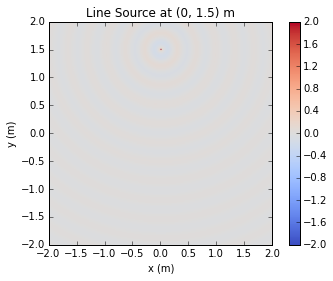

In [8]:
p_line = sfs.mono.source.line(omega, x0, None, grid)
sfs.plot.soundfield(p_line, grid)
plt.title("Line Source at {} m".format(x0[:2]));

Again, the amplitude is a bit weak, let's scale it up!
This time, the scaling factor is a bit more involved:

In [9]:
scaling_factor_line_source = np.exp(-1j*7*np.pi/4) / np.sqrt(1/(8*np.pi*omega/sfs.defs.c))

BTW, you can get (and set) the speed of sound currently used by the SFS toolbox via the variable `sfs.defs.c`.

Don't worry too much about this strange scaling factor, just multiply the sound field of the line source with it and then you're done.

*Exercise:* Scale the sound field by the given factor.

*Exercise:* Again, try different source positions and different frequencies.

*Exercise:* What's the difference between the sound fields of a point source and a line source?

### Plane Wave

Let's plot a [plane wave](http://sfs.readthedocs.org/#sfs.mono.source.plane) with a frequency of 1000 Hertz which propagates in the direction of the negative y-axis.

In [10]:
x0 = 0, 1.5, 0
n0 = 0, -1, 0
f = 1000  # Hz
omega = 2 * np.pi * f

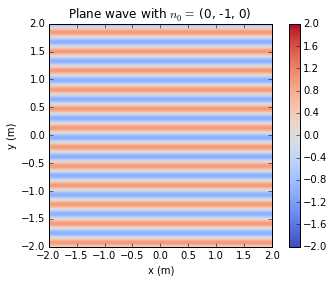

In [11]:
p_plane = sfs.mono.source.plane(omega, x0, n0, grid)
sfs.plot.soundfield(p_plane, grid);
plt.title("Plane wave with $n_0 =$ {}".format(n0));

This time, we don't need to scale the sound field.

*Exercise:* How can you see that the plane wave in the plot travels down and not up?

*Exercise:* Try different propagation angles and different frequencies.

*Exercise:* Compared to point source and line source, how does the level of the plane wave decay over distance?

## Two-channel Stereophony

As a first reproduction method, we'll have a look at *two-channel stereophony*.

In [12]:
def plot_stereo(f, weights=[1, 1]):
    """Plot a monochromatic stereo sound field.
    
    f: frequency in Hz
    weights: pair of weighting factors for the loudspeakers (can be real or complex)

    """
    omega = 2 * np.pi * f
    weights = np.asarray(weights)
    weights *= scaling_factor_point_source
    x0 = [-0.866, 1.5, 0], [0.866, 1.5, 0]
    n0 = [0, -1, 0], [0, -1, 0]
    p = sfs.mono.synthesized.generic(omega, x0, n0, weights, grid, source=sfs.mono.source.point)
    sfs.plot.soundfield(p, grid)
    sfs.plot.loudspeaker_2d(x0, n0)

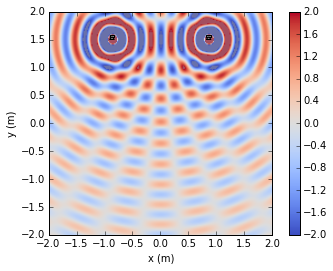

In [13]:
plot_stereo(1000)

*Exercise:* Try different frequencies.

*Exercise:* Compare the sound fields with the sound field of a single point source.
What effects can be seen in the stereo sound field?

*Exercise:* Where is the *phantom source*?

*Exercise:* Move the phantom source using *intensity stereophony*.
Try level differences of, say, 6 dB and 12 dB.

*Exercise:* Try to move the phantom source using *time-of-arrival stereophony* (using phase differences between complex weighting factors).

## A Linear Loudspeaker Array

For the following exercises, we need a [loudspeaker array](http://sfs.readthedocs.org/en/latest/#module-sfs.array).

In [14]:
x0, n0, a0 = sfs.array.linear(20, 0.15, center=[0, 1, 0], n0=[0, -1, 0])

## Wave Field Synthesis, Point Source

Let's write a little function to plot the sound field of a virtual point source reproduced by WFS:

In [15]:
def plot_wfs_point_source(f, xs):
    """Plot a point source using Wave Field Synthesis.
    
    f: frequency in Hz
    xs: position vector of the virtual source
    
    """
    omega = 2 * np.pi * f
    a = sfs.mono.drivingfunction.source_selection_point(n0, x0, xs)
    twin = sfs.tapering.tukey(a, 0.3)
    d = sfs.mono.drivingfunction.wfs_25d_point(omega, x0, n0, xs)
    p = sfs.mono.synthesized.generic(omega, x0, n0, d * twin * a0, grid, source=sfs.mono.source.point)
    sfs.plot.soundfield(p, grid)
    sfs.plot.loudspeaker_2d(x0, n0, twin)

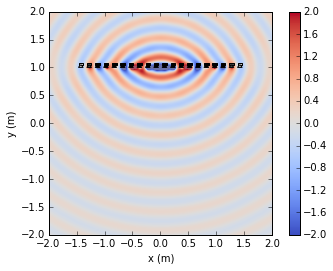

In [16]:
plot_wfs_point_source(1000, [0, 1.5, 0])

*Exercise:* Compare the plot with the sound field of an ideal point source.

*Exercise:* Increase the frequency to 2000 Hz.
Suddenly, the sound field doesn't look like that of a point source anymore.
What's the reason for the differences?

*Exercise:* Try to empirically find the frequency where those artifacts start to appear.

*Exercise:* Increase the loudspeaker distance from 15 to 20 cm.
At which frequency do the artifacts show up now?

*Exercise:* What does *2.5D* mean?

## WFS, Plane Wave

Now let's create a plane wave instead of a point source ...

Don't forget to set the loudspeaker distance to 15 cm again:

In [17]:
x0, n0, a0 = sfs.array.linear(20, 0.15, center=[0, 1, 0], n0=[0, -1, 0])

In [18]:
def plot_wfs_plane_wave(f, npw):
    """Plot a plane wave using Wave Field Synthesis.
    
    f: frequency in Hz
    npw: vector with the propagation direction of the virtual source
    
    """
    omega = 2 * np.pi * f
    a = sfs.mono.drivingfunction.source_selection_plane(n0, npw)
    twin = sfs.tapering.tukey(a, 0.3)
    d = sfs.mono.drivingfunction.wfs_25d_plane(omega, x0, n0, npw)
    p = sfs.mono.synthesized.generic(omega, x0, n0, d * twin * a0, grid, source=sfs.mono.source.point)
    sfs.plot.soundfield(p, grid)
    sfs.plot.loudspeaker_2d(x0, n0, twin)

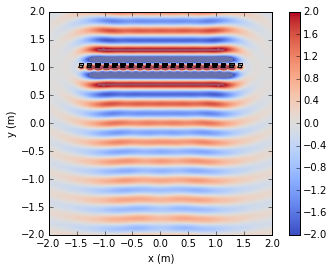

In [19]:
plot_wfs_plane_wave(1000, [0, -1, 0])

*Exercise:* Compare the plot with the sound field of an ideal plane wave.
Try different propagation angles.

*Exercise:* Change the frequency to 2000 Hz (and try some other frequencies, too).

*Exercise:* Again, change the number of loudspeakers and note what's changing in the sound field.

## A Circular Loudspeaker Array

That's easy, just have a look at the [docs](http://sfs.readthedocs.org/#sfs.array.circular).

In [20]:
x0, n0, a0 = sfs.array.circular(40, 1)

## Again, WFS Point Source

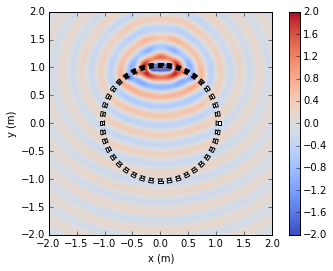

In [21]:
plot_wfs_point_source(1000, [0, 1.5, 0])

*Exercise:* Same as above: different frequencies, different distances between sources ...

## Again, WFS Plane Wave

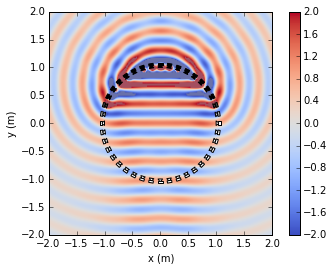

In [22]:
plot_wfs_plane_wave(1000, [0, -1, 0])

*Exercise:* Same as always ...

## Higher-Order Ambisonics

Wave Field Synthesis isn't the only sound field synthesis technique ...

Let's try nearfield-corrected higher-order Ambisonics (NFC-HOA)!

Note: NFC-HOA cannot be used with linear arrays, it only works with circular and spherical arrays.

In [23]:
def plot_hoa_plane_wave(f, npw, R):
    """Plot a plane wave using Higher-Order Ambisonics.
    
    f: frequency in Hz
    npw: vector with the propagation direction of the virtual source
    R: radius of the loudspeaker array in metres
    
    """
    omega = 2 * np.pi * f
    d = sfs.mono.drivingfunction.nfchoa_25d_plane(omega, x0, R, npw)
    p = sfs.mono.synthesized.generic(omega, x0, n0, d * a0, grid, source=sfs.mono.source.point)
    p /= 4 * np.pi  # ad hoc scaling factor
    sfs.plot.soundfield(p, grid)
    sfs.plot.loudspeaker_2d(x0, n0)

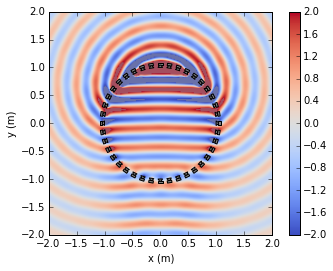

In [24]:
plot_hoa_plane_wave(1000, [0, -1, 0], 1)

*Exercise:* Same ...

*Exercise:* WFS vs. NFC-HOA: How do the artifacts for higher frequencies differ?

Finally, let's try to reproduce a virtual point source with NFC-HOA:

In [25]:
def plot_hoa_point_source(f, xs, R):
    """Plot a point source using Higher-Order Ambisonics.
    
    f: frequency in Hz
    xs: position vector of the virtual source
    R: radius of the loudspeaker array in metres
    
    """
    omega = 2 * np.pi * f
    d = sfs.mono.drivingfunction.nfchoa_25d_point(omega, x0, R, xs)
    p = sfs.mono.synthesized.generic(omega, x0, n0, d * a0, grid, source=sfs.mono.source.point)
    p *= 4 * np.pi  # ad hoc scaling factor
    sfs.plot.soundfield(p, grid)
    sfs.plot.loudspeaker_2d(x0, n0)

In [26]:
x0, n0, a0 = sfs.array.circular(40, 1)

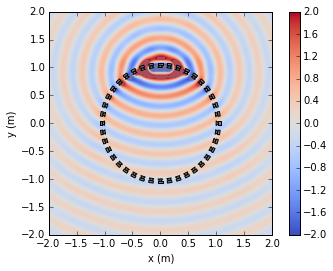

In [27]:
plot_hoa_point_source(1000, [0, 1.5, 0], 1)

*Exercise:* As always ...

## Solutions

If you had problems solving some of the exercises, don't despair!
Have a look at the [example solutions](reproduction-solutions.ipynb).

<p xmlns:dct="http://purl.org/dc/terms/">
  <a rel="license"
     href="http://creativecommons.org/publicdomain/zero/1.0/">
    <img src="http://i.creativecommons.org/p/zero/1.0/88x31.png" style="border-style: none;" alt="CC0" />
  </a>
  <br />
  To the extent possible under law,
  <span rel="dct:publisher" resource="[_:publisher]">the person who associated CC0</span>
  with this work has waived all copyright and related or neighboring
  rights to this work.
</p>